In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_target = pd.read_csv('gender_submission.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [4]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


# Select most important features that effect on target

## Feature Importance with Random Forest
We'll train a Random Forest model and extract feature importances.

C:\Users\youse\AppData\Local\Temp\ipykernel_24100\189703826.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
C:\Users\youse\AppData\Local\Temp\ipykernel_24100\189703826.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

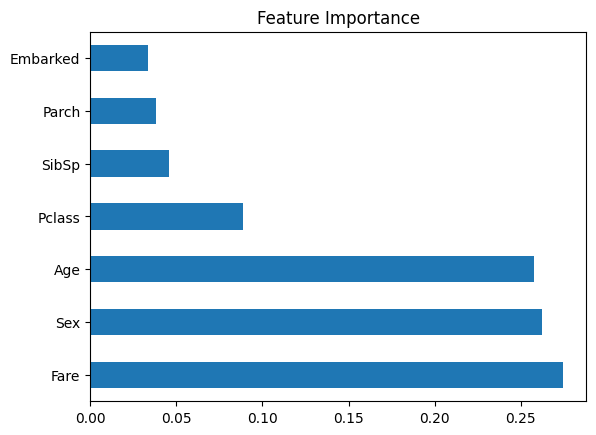

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Preprocessing: Fill missing values and encode categorical features
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
train.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)  # Dropping columns with too many missing values or not useful
train['Sex'] = LabelEncoder().fit_transform(train['Sex'])
train['Embarked'] = LabelEncoder().fit_transform(train['Embarked'])

# Separating features and target
X = train.drop(['PassengerId', 'Survived'], axis=1)
y = train['Survived']

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.show()

## Permutation Importance
We'll calculate permutation importance using a trained model.

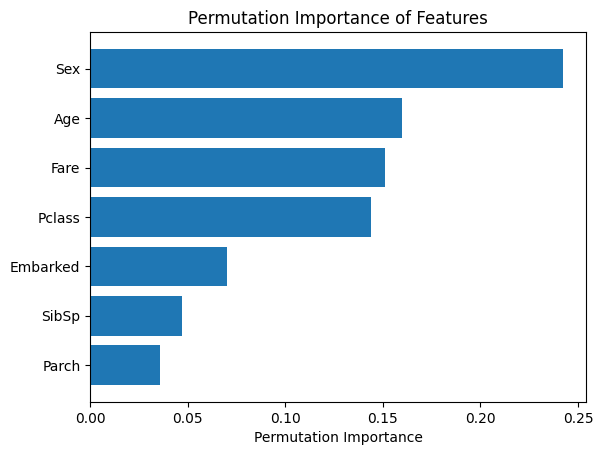

In [6]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

# plt.figure(figsize=(10, 8))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title('Permutation Importance of Features')
plt.show()

## Recursive Feature Elimination (RFE)
We'll use RFE with a Random Forest model to select the most important features.

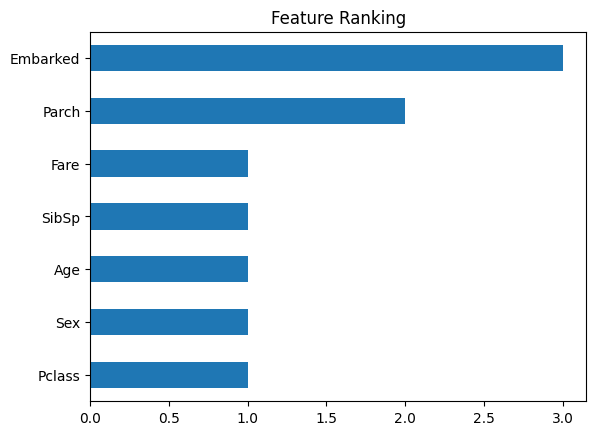

In [7]:
from sklearn.feature_selection import RFE

# Initialize the model
# model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the model
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

# Get the ranking of the features
ranking = rfe.ranking_

# Plot the ranking of the features
feature_ranking = pd.Series(ranking, index=X.columns).sort_values()
feature_ranking.plot(kind='barh')
plt.title('Feature Ranking')
plt.show()

## Statistical Tests (Chi-Squared Test and ANOVA)
For categorical features, we can perform a Chi-Squared test, and for continuous features, an ANOVA test.

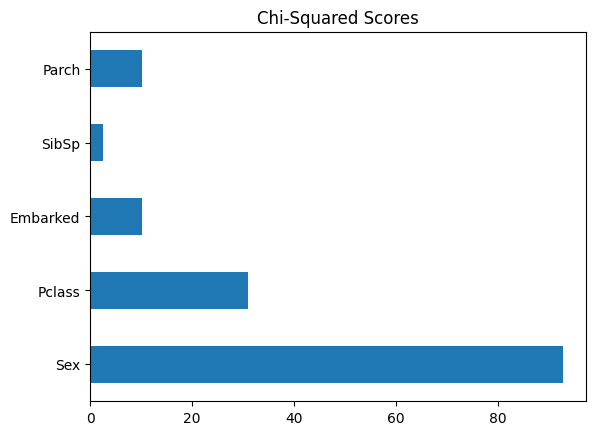

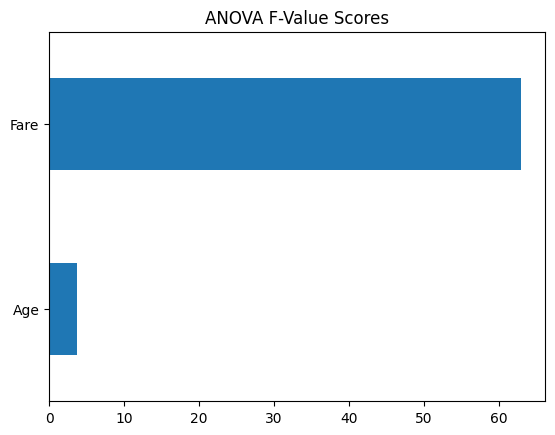

In [8]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Chi-Squared Test for categorical features
X_cat = train[['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']]
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_cat, y)

chi2_scores = pd.Series(chi2_selector.scores_, index=X_cat.columns)
chi2_scores.plot(kind='barh')
plt.title('Chi-Squared Scores')
plt.show()

# ANOVA Test for continuous features
X_cont = train[['Age', 'Fare']]
anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X_cont, y)

anova_scores = pd.Series(anova_selector.scores_, index=X_cont.columns)
anova_scores.plot(kind='barh')
plt.title('ANOVA F-Value Scores')
plt.show()

## Correlation Analysis
We will calculate and visualize the correlation matrix for the numeric features to see how they correlate with the target variable (Survived).

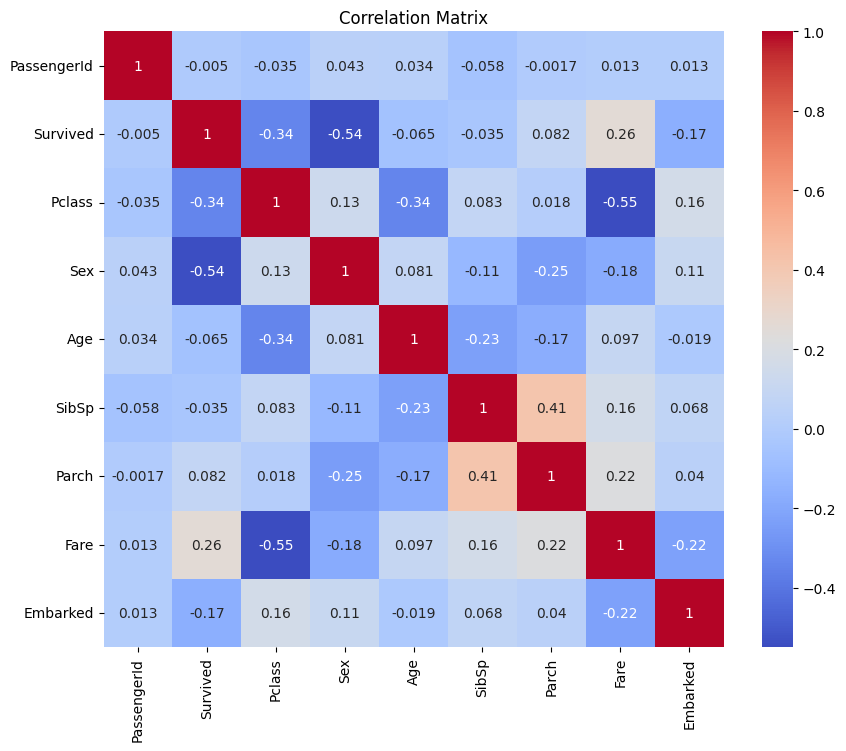

In [9]:
# correlation analysis
corr_matrix = train.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Modelling

## Preprocessing
Fill missing values and encode categorical features

In [10]:
test['Age'].fillna(test['Age'].median(), inplace=True)
test['Fare'].fillna(test['Fare'].median(), inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)
test['Sex'] = LabelEncoder().fit_transform(test['Sex'])
test['Embarked'] = LabelEncoder().fit_transform(test['Embarked'])

C:\Users\youse\AppData\Local\Temp\ipykernel_24100\3444374115.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Age'].fillna(test['Age'].median(), inplace=True)
C:\Users\youse\AppData\Local\Temp\ipykernel_24100\3444374115.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

## Separation & Standardization

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separating features and target
X_train = train[['Sex', 'Pclass', 'Embarked', 'Fare', 'Age']]
y_train = train['Survived']
X_test = test[['Sex', 'Pclass', 'Embarked', 'Fare', 'Age']]
y_test = test_target['Survived']


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Train & Test Decision Tree

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 6}
Best accuracy found:  0.8237775406440273
Best Decision Tree Accuracy: 0.8899521531100478
Best Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       266
           1       0.88      0.81      0.84       152

    accuracy                           0.89       418
   macro avg       0.89      0.87      0.88       418
weighted avg       0.89      0.89      0.89       418



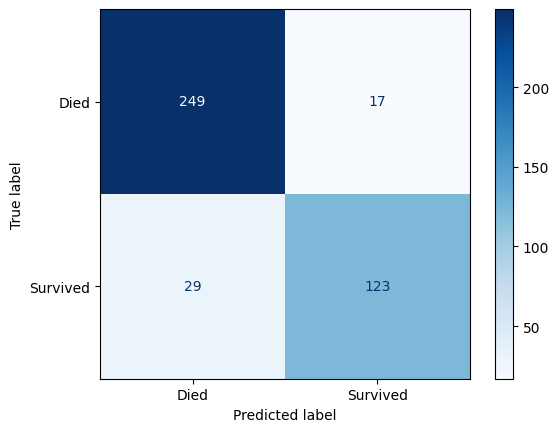

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test_scaled)

# Evaluate the best model
print("Best Decision Tree Accuracy:", accuracy_score(y_test, y_pred_best_dt))
print("Best Decision Tree Classification Report:\n", classification_report(y_test, y_pred_best_dt))

# Plot the confusion matrix
classes = ['Died', 'Survived']
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_dt, display_labels=classes, cmap=plt.cm.Blues)

plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

## Train & Test Random Forest

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
Best accuracy found:  0.8395141547925429
Best Random Forest Accuracy: 0.8875598086124402
Best Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       266
           1       0.87      0.81      0.84       152

    accuracy                           0.89       418
   macro avg       0.88      0.87      0.88       418
weighted avg       0.89      0.89      0.89       418



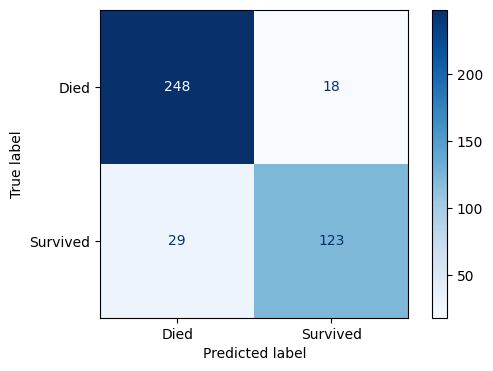

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the Random Forest model
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Evaluate the best model
print("Best Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Best Random Forest Classification Report:\n", classification_report(y_test, y_pred_best_rf))

# Plot the confusion matrix
classes = ['Died', 'Survived']
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_rf, display_labels=classes, cmap=plt.cm.Blues)

plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

## Train & Test Adaboost

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\youse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found:  {'learning_rate': 1.0, 'n_estimators': 100}
Best accuracy found:  0.8170987383089574
Best AdaBoost Accuracy: 0.861244019138756
Best AdaBoost Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       266
           1       0.79      0.84      0.82       152

    accuracy                           0.86       418
   macro avg       0.85      0.86      0.85       418
weighted avg       0.86      0.86      0.86       418



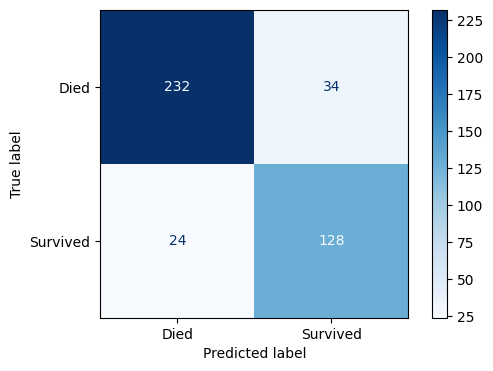

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1.0]
}

# Initialize the AdaBoost model
ada = AdaBoostClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_ada = grid_search.best_estimator_
y_pred_best_ada = best_ada.predict(X_test_scaled)

# Evaluate the best model
print("Best AdaBoost Accuracy:", accuracy_score(y_test, y_pred_best_ada))
print("Best AdaBoost Classification Report:\n", classification_report(y_test, y_pred_best_ada))

# Plot the confusion matrix
classes = ['Died', 'Survived']
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_ada, display_labels=classes, cmap=plt.cm.Blues)

plt.rcParams['figure.figsize'] = [6, 4]
plt.show()